In [2]:
! pip install -q kaggle

In [3]:
!pip install torchinfo

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fizarazvi10","key":"8b8b01fb838f83650c5dc57ed3c48e9d"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download ashishmotwani/tomato


100% 1.37G/1.37G [00:15<00:00, 106MB/s]

100% 1.37G/1.37G [00:15<00:00, 93.8MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('tomato.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torchinfo import summary
#import mlflow
from torch.utils.data import Subset
from torchvision.models import Inception_V3_Weights

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.set_experiment("inceptionv3-tomato")

In [5]:
import gc
gc.collect()

36

In [ ]:
def tv_split(dataset,split_size=0.25):
    print(len(dataset))
    train_idx, val_idx = torch.utils.data.random_split(dataset,[25787,64])
    datasets = {}
    print(train_idx)
    datasets['train'] = train_idx
    datasets['validation'] = val_idx
    return datasets

In [6]:
transform = transforms.Compose([transforms.Resize((300,300)), transforms.ToTensor(), transforms.RandomHorizontalFlip()])
traindata = datasets.ImageFolder("/kaggle/input/tomato/train", transform=transform)
validdata = datasets.ImageFolder("/kaggle/input/tomato/valid", transform=transform)

# Divide the validdata into validation and test sets (50% each)
total_size = len(validdata)
valid_size = int(0.5 * total_size)
test_size = total_size - valid_size
valid_data, test_data = torch.utils.data.random_split(validdata, [valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(traindata, batch_size=60, shuffle=True)
validationloader = torch.utils.data.DataLoader(valid_data, batch_size=60, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=60, shuffle=True)

loader = {'train': trainloader, 'validation': validationloader, 'test': testloader}

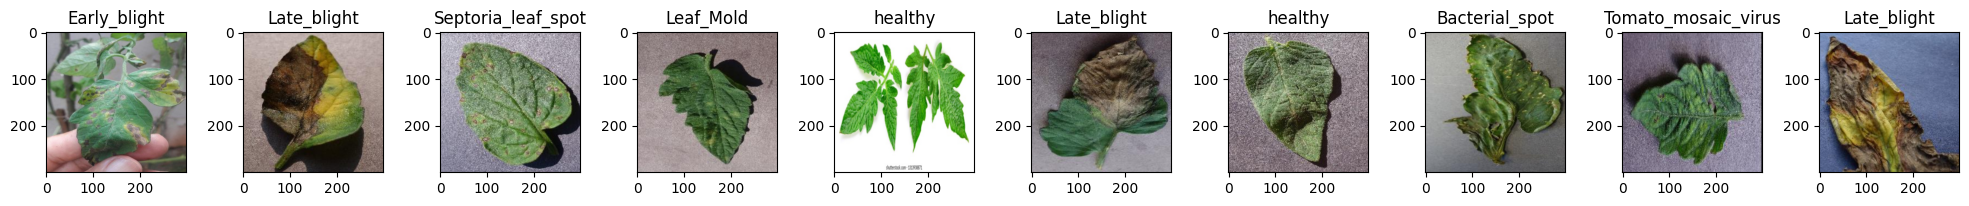

In [7]:
def im_convert(tensor):
  img = tensor.clone().detach().numpy()
  img  = img.transpose(1,2,0)
  # img = img*np.array(([0.485, 0.456, 0.406])/np.array(([0.229, 0.224, 0.225])))
  return img

dataiter = iter(validationloader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25,4))
for i in np.arange(10):
  ax = fig.add_subplot(2,10, i+1)
  plt.imshow(im_convert(images[i]))
  ax.set_title(traindata.classes[labels[i].item()])

In [8]:
running_loss_history = []
val_running_loss_historu = []

running_loss_correct = []
val_running_loss_correct = []
epochs = 20

def train(model, epochs=20):
  history = {
        "running_loss_history": [],
        "val_running_loss_history": [],
        "running_accuracy_history": [],
        "val_running_accuracy_history": []
    }
  for i in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0

    running_correct = 0.0
    val_running_correct = 0.0

    for inputs, labels in trainloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs,_ = model(inputs)
      optimizer.zero_grad()
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      _,pred = torch.max(outputs,1)
      running_correct+=torch.sum(pred==labels.data)

    else:
      #model.eval()
      with torch.no_grad():
        for val_inputs, val_labels in validationloader:
          val_inputs,val_labels = val_inputs.to(device), val_labels.to(device)
          val_outputs = model(val_inputs)

          if isinstance(val_outputs, tuple):
             # If model returns a tuple of outputs, select the first output
             val_outputs = val_outputs[0]
          val_loss = loss_fn(val_outputs, val_labels)
          _,val_pred = torch.max(val_outputs,1)
          val_running_correct+=torch.sum(val_pred==val_labels.data)
          val_running_loss+=val_loss.item()

      val_epoch_accuracy = val_running_correct.float()/len(validationloader.dataset)
      val_epoch_loss = val_running_loss/len(validationloader.dataset)
      val_running_loss_historu.append(val_epoch_loss)
      val_running_loss_correct.append(val_epoch_accuracy)
      history["val_running_loss_history"].append(val_epoch_loss)
      history["val_running_accuracy_history"].append(val_epoch_accuracy)

      epoch_accuracy = running_correct.float()/len(trainloader.dataset)

      epoch_loss = running_loss/len(trainloader.dataset)
      running_loss_history.append(epoch_loss)
      running_loss_correct.append(epoch_accuracy)
      history["running_loss_history"].append(epoch_loss)
      history["running_accuracy_history"].append(epoch_accuracy)

      print("Epoch:{}".format(i))
      print("Training loss:{} and Accuracy:{}".format(epoch_loss, epoch_accuracy.item()))
      print("Validation loss: {} and Accuracy:{}".format(val_epoch_loss, val_epoch_accuracy.item()))
  return history

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def test(model, testloader):
    model.eval()  # Set the model to evaluation mode
    test_correct = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for test_inputs, test_labels in testloader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            if isinstance(test_outputs, tuple):
                # If model returns a tuple of outputs, select the first output
                test_outputs = test_outputs[0]
            _, test_pred = torch.max(test_outputs, 1)
            test_correct += torch.sum(test_pred == test_labels.data)
            all_labels.extend(test_labels.cpu().numpy())
            all_predictions.extend(test_pred.cpu().numpy())

    test_accuracy = test_correct.item() / len(testloader.dataset)
    test_precision = precision_score(all_labels, all_predictions, average='macro')
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1 = f1_score(all_labels, all_predictions, average='macro')

    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_scratch.png')
    plt.show()


# **Pretrained=False**

In [13]:
model = models.inception_v3(pretrained=False);
in_features = model.fc.in_features
model.fc=nn.Linear(in_features, len(traindata.classes))
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [14]:
# with mlflow.start_run() as run:
#     params = {
#         "epochs":epochs,
#         "learning_rate":1e-3,
#         "batch_size":60,
#         "loss_function": loss_fn.__class__.__name__,
#         "optimizer": "SGD",
#     }
#     mlflow.log_params(params)
#     with open("model_summary.txt", "w",encoding="utf-8") as f:
#         f.write(str(summary(model)))
#     mlflow.log_artifact("model_summary.txt")
results = {}
results['scratch'] = train(model, 10)
    # mlflow.pytorch.log_model(model, "model")


Epoch:0
Training loss:0.033006859602243276 and Accuracy:0.29863446950912476
Validation loss: 0.027760912186726237 and Accuracy:0.4325052499771118
Epoch:1
Training loss:0.02487281077945953 and Accuracy:0.475107342004776
Validation loss: 0.022500120069908546 and Accuracy:0.5444477796554565
Epoch:2
Training loss:0.02046850727059238 and Accuracy:0.5775018334388733
Validation loss: 0.01828197212998505 and Accuracy:0.6306495070457458
Epoch:3
Training loss:0.0178019333257421 and Accuracy:0.6362616419792175
Validation loss: 0.01675717017494323 and Accuracy:0.6566896438598633
Epoch:4
Training loss:0.015490519915608012 and Accuracy:0.6832230687141418
Validation loss: 0.01497263069532475 and Accuracy:0.695300817489624
Epoch:5
Training loss:0.013909898475541685 and Accuracy:0.715639591217041
Validation loss: 0.01326028077197767 and Accuracy:0.7384017109870911
Epoch:6
Training loss:0.01282869515430627 and Accuracy:0.7408997416496277
Validation loss: 0.012777268511918589 and Accuracy:0.7404968738555

Test Accuracy: 0.8432
Test Precision: 0.8309
Test Recall: 0.8310
Test F1 Score: 0.8298


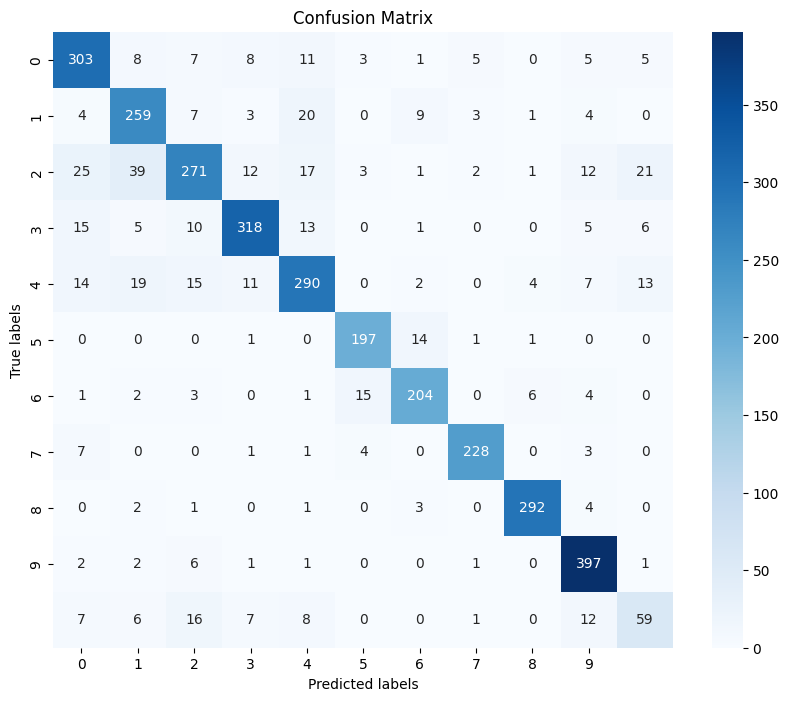

In [25]:
test(model, testloader)

In [17]:
import json

import numpy as np

# Convert tensors to lists or NumPy arrays before serializing
for key, value in results['scratch'].items():
    if isinstance(value, list):
        # Convert lists of tensors to lists of numpy arrays
        value = [tensor.tolist() if isinstance(tensor, torch.Tensor) else tensor for tensor in value]
    elif isinstance(value, torch.Tensor):
        # Convert single tensors to numpy arrays
        value = value.tolist()
    results['scratch'][key] = value

# Store the results in a JSON file
with open('results.json', 'w') as f:
    json.dump(results, f)

print("Results saved to 'results.json'")

Results saved to 'results.json'


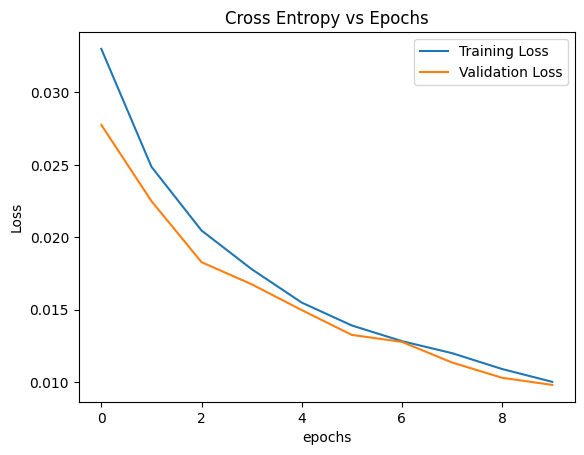

In [26]:
plt.plot(running_loss_history, label = "Training Loss")
plt.plot(val_running_loss_historu, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Cross Entropy vs Epochs")
plt.legend()

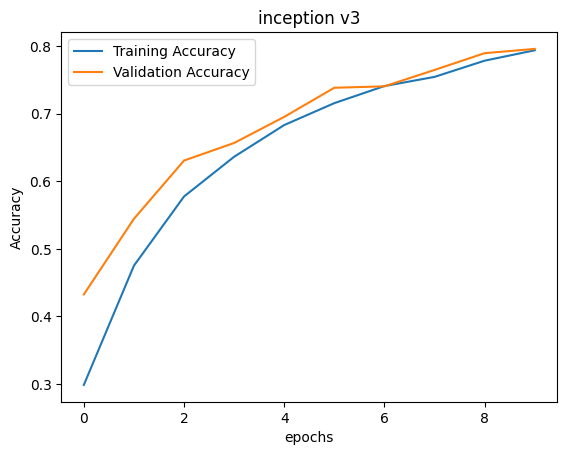

In [27]:
running_loss_correct = [i.cpu() for i in running_loss_correct]
val_running_loss_correct = [i.cpu() for i in val_running_loss_correct]
plt.plot(running_loss_correct, label = "Training Accuracy")
plt.plot(val_running_loss_correct, label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("inception v3")
plt.legend()

In [18]:
torch.save(model, './inceptionV3_tomato_scratch.pth')

In [29]:
classes = traindata.classes
classes

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

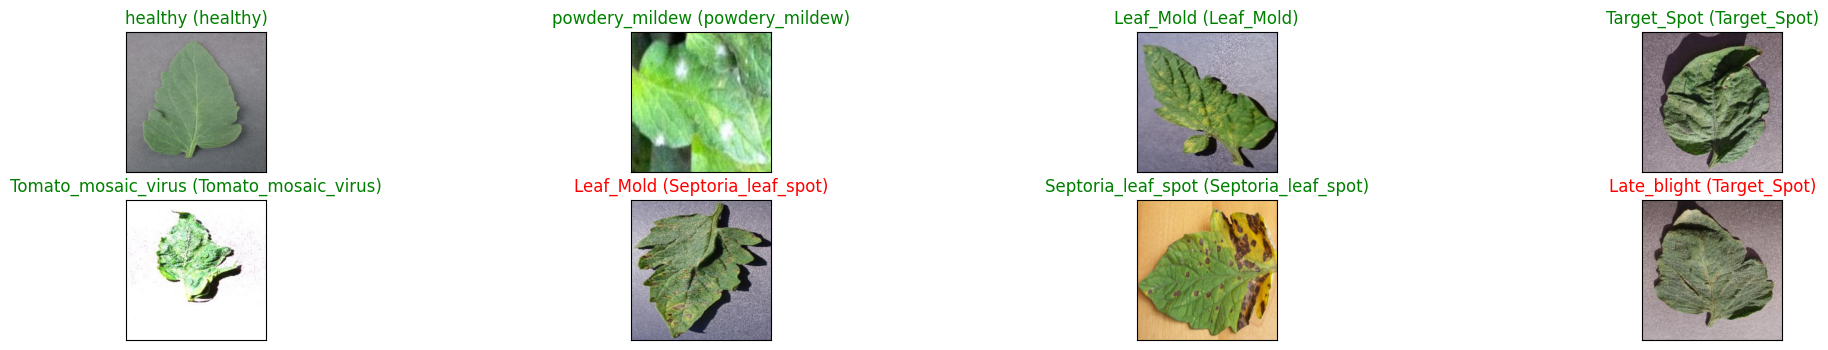

In [ ]:
import numpy as np

dataiter = iter(validationloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
model1 = torch.load("/kaggle/working/inceptionV3_tomato_scratch.pth")
output, _ = model1(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx] == labels[idx] else "red"))

# **Pretrained=True**

In [16]:
pre_trained_model = torchvision.models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
in_features = pre_trained_model.fc.in_features
pre_trained_model.fc=nn.Linear(in_features, len(traindata.classes))
pre_trained_model = pre_trained_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(pre_trained_model.parameters(), lr = 0.01)

In [17]:
results = {}
results['pretrained'] = train(pre_trained_model, 10)

Epoch:0
Training loss:0.014606833516742121 and Accuracy:0.7374569177627563
Validation loss: 0.005040411127965916 and Accuracy:0.9111045002937317
Epoch:1
Training loss:0.00369223582487974 and Accuracy:0.9305248856544495
Validation loss: 0.002934784786505315 and Accuracy:0.9461239576339722
Epoch:2
Training loss:0.0018015097492969242 and Accuracy:0.9668871164321899
Validation loss: 0.002271257204875301 and Accuracy:0.9601916074752808
Epoch:3
Training loss:0.001105236079594122 and Accuracy:0.980735719203949
Validation loss: 0.0017571352440077757 and Accuracy:0.9676743745803833
Epoch:4
Training loss:0.000700233374750727 and Accuracy:0.9889365434646606
Validation loss: 0.0016084357395609833 and Accuracy:0.9727627038955688
Epoch:5
Training loss:0.0005139770302098687 and Accuracy:0.9917604327201843
Validation loss: 0.0014832489421344186 and Accuracy:0.9745585322380066
Epoch:6
Training loss:0.00037482843010298227 and Accuracy:0.9938880205154419
Validation loss: 0.0015058749117318455 and Accurac

Test Accuracy: 0.9856
Test Precision: 0.9870
Test Recall: 0.9866
Test F1 Score: 0.9868


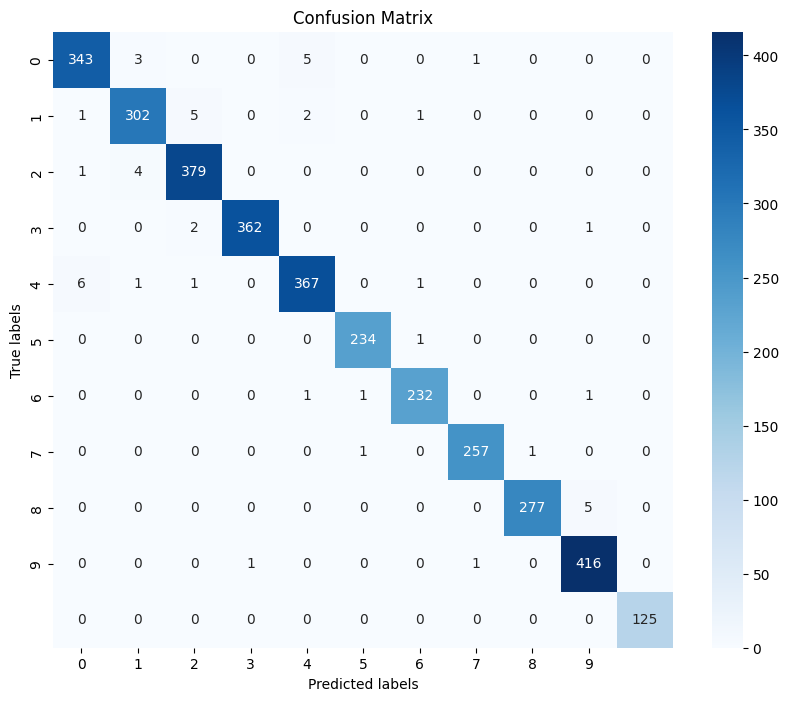

In [20]:
test(pre_trained_model, testloader)

In [22]:
torch.save(pre_trained_model, './inceptionV3_tomato_pretrained.pth')

In [23]:
import json

import numpy as np

# Convert tensors to lists or NumPy arrays before serializing
for key, value in results['pretrained'].items():
    if isinstance(value, list):
        # Convert lists of tensors to lists of numpy arrays
        value = [tensor.tolist() if isinstance(tensor, torch.Tensor) else tensor for tensor in value]
    elif isinstance(value, torch.Tensor):
        # Convert single tensors to numpy arrays
        value = value.tolist()
    results['pretrained'][key] = value

# Store the results in a JSON file
with open('results_pretrained.json', 'w') as f:
    json.dump(results, f)

print("Results saved to 'results.json'")

Results saved to 'results.json'


In [ ]:
plt.plot(running_loss_history, label = "Training Loss")
plt.plot(val_running_loss_historu, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Cross Entropy vs Epochs")
plt.legend()

In [ ]:
running_loss_correct = [i.cpu() for i in running_loss_correct]
val_running_loss_correct = [i.cpu() for i in val_running_loss_correct]
plt.plot(running_loss_correct, label = "Training Accuracy")
plt.plot(val_running_loss_correct, label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("inception v3")
plt.legend()

In [24]:
import numpy as np

dataiter = iter(validationloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
model1 = torch.load("/kaggle/working/inceptionV3_tomato_pretrained.pth")
output, _ = model1(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx] == labels[idx] else "red"))

NameError: name 'imshow' is not defined